In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.interpolate import interp1d

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/'

In [3]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','omega'
           ,'Plead_P','Plead_theta','Plead_phi','Precoil_P','Precoil_theta','Precoil_phi'
           ,'electron_phi','electron_theta'] # ,'Mott','DipoleFF2'
eep_300Pmiss600_NoFid , eepp_300Pmiss600_NoFid = dict() , dict()
eep_300Pmiss600_Fid , eepp_300Pmiss600_Fid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    eep_300Pmiss600_NoFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e1p_adjusted_300Pmiss600_%s_NoPrecFiducials.root"%target, columns=columns )
    eepp_300Pmiss600_NoFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_NoPrecFiducials.root"%target, columns=columns )    
    eep_300Pmiss600_Fid[target] = read_root( path+"/Analysis_DATA/ppSRCcm/DATA_300Pmiss600/SRC_e1p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )    
    eepp_300Pmiss600_Fid[target] = read_root( path+"/Analysis_DATA/ppSRCcm/DATA_300Pmiss600/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    print len(eep_300Pmiss600_NoFid[target]),'events in',"SRC_e1p_adjusted_300Pmiss600_%s_NoPrecFiducials.root"%target
    print len(eepp_300Pmiss600_NoFid[target]),'events in',"SRC_e2p_adjusted_300Pmiss600_%s_NoPrecFiducials.root"%target    

7598 events in SRC_e1p_adjusted_300Pmiss600_C12_NoPrecFiducials.root
294 events in SRC_e2p_adjusted_300Pmiss600_C12_NoPrecFiducials.root
2573 events in SRC_e1p_adjusted_300Pmiss600_Al27_NoPrecFiducials.root
93 events in SRC_e2p_adjusted_300Pmiss600_Al27_NoPrecFiducials.root
8588 events in SRC_e1p_adjusted_300Pmiss600_Fe56_NoPrecFiducials.root
247 events in SRC_e2p_adjusted_300Pmiss600_Fe56_NoPrecFiducials.root
2635 events in SRC_e1p_adjusted_300Pmiss600_Pb208_NoPrecFiducials.root
49 events in SRC_e2p_adjusted_300Pmiss600_Pb208_NoPrecFiducials.root


In [4]:
def acceptance_2d(hdenom = None, hnum = None):
    hratio = np.zeros((len(hnum[:,0]),len(hdenom[0,:])))
    for i in range(len(hnum[:,0])):
        for j in range(len(hnum[0,:])):
            if hdenom[i,j]>0:
                hratio[i,j] = hnum[i,j]/hdenom[i,j]            
    return hratio

In [5]:
ran_eepp_eep = dict({'min_p':0.35,'max_p':0.6,'ratio extrapolated':9.56,'ratio extrapolated err':2.43,'ratio halfed':4.78,'ratio halfed err':1.21})
print 'ran_eepp_eep:\n',ran_eepp_eep
Tp = dict({'C12':0.53,'Al27':0.43,'Fe56':0.34,'Pb208':0.22,'C12err':0.05,'Al27err':0.05,'Fe56err':0.04,'Pb208err':0.03})
Tpp = dict({'C12':0.44,'Al27':0.35,'Fe56':0.26,'Pb208':0.16,'C12err':0.04,'Al27err':0.04,'Fe56err':0.03,'Pb208err':0.02})
Pscx = dict({'C12':0.02,'Al27':0.03,'Fe56':0.04,'Pb208':0.07,'C12err':0.02,'Al27err':0.03,'Fe56err':0.04,'Pb208err':0.06})
Z = dict({'C12':6,'Al27':13,'Fe56':26,'Pb208':82})
N = dict({'C12':6,'Al27':14,'Fe56':30,'Pb208':126})

def np2pp_from_eepp2eep_Or( Tpp=0.44 , Tp=0.53 , Pscx=0.02 , R=0.08 , N=6 , Z=6):
    # using Or' notation in Science
    # with replacing Trec by Tpp
    # since its bullshit
    sigma_n2p = 1./2.5
    numerator = Tpp - Tp*R - R*sigma_n2p*Pscx
    denominator = 0.5*R*(Tp + sigma_n2p*Pscx) - 0.5*sigma_n2p*Pscx*Tpp*((N*(N-1.))/(Z*(Z-1.)))
    return (numerator/denominator)



TppWim = dict({'C12':0.28,'Al27':0.186,'Fe56':0.138,'Pb208':0.073})
Tstar = dict({'C12':0.283,'Al27':0.186,'Fe56':0.144,'Pb208':0.083})
PscxWim = dict({'C12':dict({'P([n]p)':0.035,'P(n[p])':0.041,'P([p]p)':0.041,'P(p[p])':0.048,'P([p]n)':0.035,'P(p[n])':0.041,'P([n]n)':0.041,'P(nocx-pp)':0.91,'P(nocx-pn)':0.92})
             ,'Al27':dict({'P([n]p)':0.04,'P(n[p])':0.051,'P([p]p)':0.046,'P(p[p])':0.054,'P([p]n)':0.043,'P(p[n])':0.047,'P([n]n)':0.042,'P(nocx-pp)':0.90,'P(nocx-pn)':0.91})
             ,'Fe56':dict({'P([n]p)':0.04,'P(n[p])':0.055,'P([p]p)':0.048,'P(p[p])':0.057,'P([p]n)':0.046,'P(p[n])':0.047,'P([n]n)':0.042,'P(nocx-pp)':0.89,'P(nocx-pn)':0.90})
             ,'Pb208':dict({'P([n]p)':0.04,'P(n[p])':0.072,'P([p]p)':0.059,'P(p[p])':0.073,'P([p]n)':0.06,'P(p[n])':0.047,'P([n]n)':0.039,'P(nocx-pp)':0.86,'P(nocx-pn)':0.89})})

def np2pp_from_eepp2eep_Wim( Tpp=TppWim['C12'] , Tp=Tp['C12'] , Tstar=Tstar['C12']
                            , PWim=PscxWim['C12'] , R=0.08 , N=N['C12'] , Z=Z['C12']):
    # using Wim' scheme
    sigma_n2p = 1./2.5
    NZ_factor = (N*(N-1))/(Z*(Z-1))
    
    num_p1 = 2.*(Tpp*PWim['P(nocx-pp)'] - PWim['P([p]p)'] - PWim['P(p[p])'])
    num_p2 = -2.*R*Tp*(1. - PWim['P([p]p)'] + NZ_factor*sigma_n2p*PWim['P([n]n)'])
    numerator = num_p1 + num_p2
    
    den_p1 = R*Tp*(1. - PWim['P([p]n)'] + sigma_n2p*PWim['P([n]p)'])
    den_p2 = -Tstar*(sigma_n2p*PWim['P([n]p)'] + PWim['P(p[n])'])
    denominator = den_p1 + den_p2
    return (numerator/denominator)

ran_eepp_eep:
{'max_p': 0.6, 'ratio extrapolated': 9.56, 'ratio extrapolated err': 2.43, 'min_p': 0.35, 'ratio halfed err': 1.21, 'ratio halfed': 4.78}


In [6]:
# np2pp_from_eepp2eep(R=0.0956)
# check...
R=0.04
for target in ['C12','Al27','Fe56','Pb208']:
    print target+':'
    print 'Or scheme:',np2pp_from_eepp2eep_Or(Tpp=Tpp[target],Tp=Tp[target],Pscx=Pscx[target]
                                         ,N=N[target],Z=Z[target]
                                         ,R=R)
    print 'Wim scheme:',np2pp_from_eepp2eep_Wim(Tpp=Tpp[target],Tp=Tp[target],PWim=PscxWim[target]
                                         ,N=N[target],Z=Z[target]
                                         ,R=R)

C12:
Or scheme: 46.4977777778
Wim scheme: 112.035731627
Al27:
Or scheme: 52.0062597809
Wim scheme: -362.725882568
Fe56:
Or scheme: 56.6789667897
Wim scheme: -48.8351606642
Pb208:
Or scheme: -426.784217016
Wim scheme: 0.627718187804


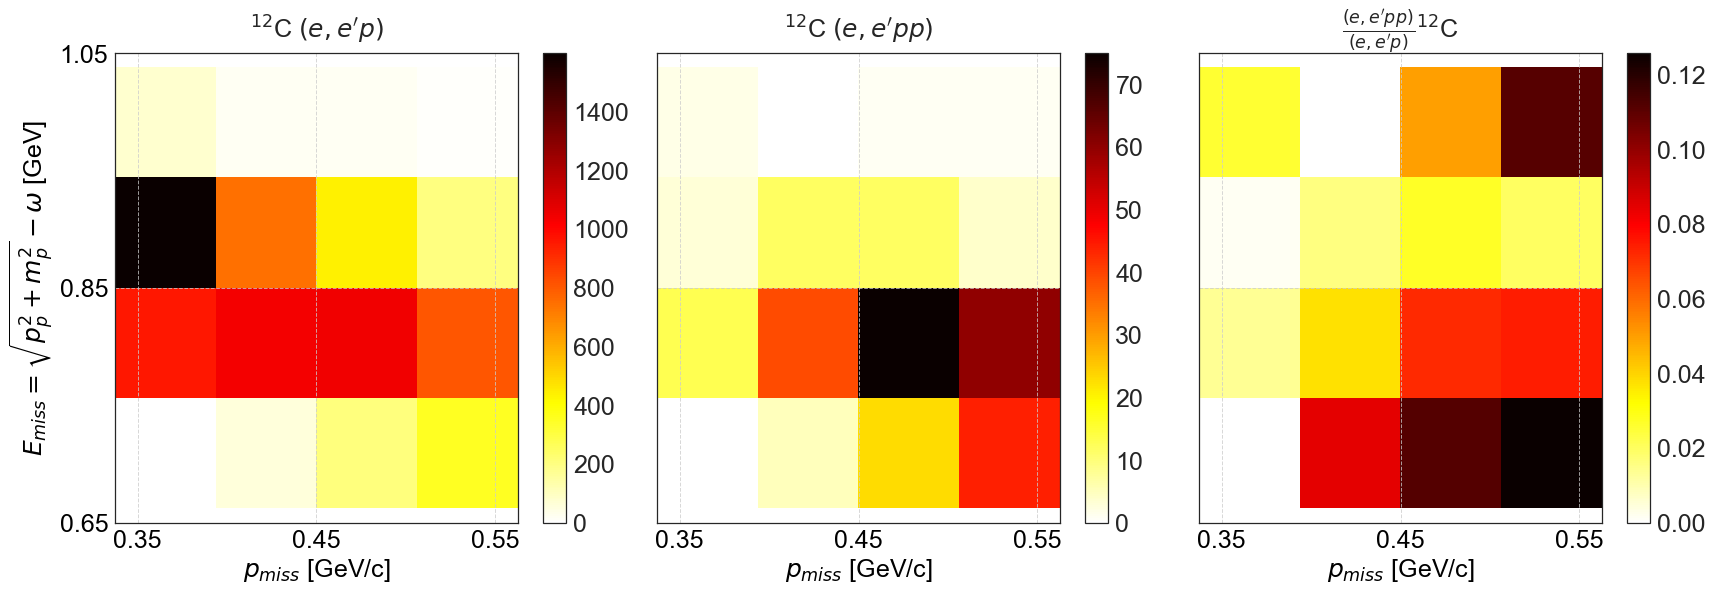

In [7]:
bins = (np.linspace(0.3,0.6,5),np.linspace(0.6,1.1,5))

fig = plt.figure(figsize=(24,30))
h = dict()
for i_tgt,(target,name) in enumerate(zip(['C12']#,'Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    
    h[target] = dict()
    for isample,(sample,slabel) in enumerate(zip([eep_300Pmiss600_NoFid[target],eepp_300Pmiss600_NoFid[target]]                      
                                                 ,[r"$(e,e'p)$",r"$(e,e'pp)$"])):
        Pmiss = sample['Pmiss3Mag']
        Emiss = np.sqrt(np.square(sample['Plead_P'])+np.square(0.938))-sample['omega']
        data_array = np.array( [Pmiss , Emiss ] )
        h[target][slabel],edges = np.histogramdd( data_array.T,bins=bins )

        Pmiss_centres = (edges[0][:-1] + edges[0][1:])/2
        Emiss_centres = (edges[1][:-1] + edges[1][1:])/2
        Pm,Em = np.meshgrid(Pmiss_centres,Emiss_centres)

        ax = fig.add_subplot(4,3,4*i_tgt+isample+1)
        im = ax.imshow(h[target][slabel].reshape(len(Pmiss_centres),len(Emiss_centres)).T
                       ,cmap='hot_r',origin='bottom'
                       ,extent=(Pmiss_centres.min(), Pmiss_centres.max(), Emiss_centres.min(), Emiss_centres.max()))
        ax.set_aspect('auto')
        cbar = plt.colorbar(im)
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=25)
        set_axes(ax,r'$p_{miss}$ [GeV/c]' if i_tgt==0 else ''
             ,r'$E_{miss}=\sqrt{p_p^2+m_p^2}-\omega$ [GeV]' if isample==0 else ''
             ,xticks=[0.35,0.45,0.55],yticks=[0.65,0.85,1.05]
                 ,do_add_grid=True,do_add_legend=True,title=name+' '+slabel)

        if isample>0: ax.get_yaxis().set_major_formatter(ticker.NullFormatter())


        
    h[target][r"$(e,e'pp)/(e,e'p)$"] = acceptance_2d(hdenom = h[target][r"$(e,e'p)$"]
                                                     ,hnum = h[target][r"$(e,e'pp)$"])
    histo = h[target][r"$(e,e'pp)/(e,e'p)$"]

    
    eep = h[target][r"$(e,e'p)$"]
    eepp = h[target][r"$(e,e'pp)$"]
    h[target][r"$#np/#pp$"] = np.zeros((len(eep[:,0]),len(eep[0,:])))
    for i in range(len(eep[:,0])):
        for j in range(len(eep[0,:])):
            if eep[i,j]>0: R = eepp[i,j]/eep[i,j]
            else:  R = 0
            h[target][r"$#np/#pp$"][i,j] = np2pp_from_eepp2eep_Wim(Tpp=Tpp[target]
                                                                       ,Tp=Tp[target]
                                                                       ,PWim=PscxWim[target]                                         
                                                                       ,N=N[target],Z=Z[target]                                         
                                                                       ,R=R)
    
    ax = fig.add_subplot(4,3,4*i_tgt+3)
#     histo = h[target][r"$#np/#pp$"]
    im = ax.imshow(histo.reshape(len(Pmiss_centres),len(Emiss_centres)).T
                       ,cmap='hot_r',origin='bottom'
                       ,extent=(Pmiss_centres.min(), Pmiss_centres.max(), Emiss_centres.min(), Emiss_centres.max()))
    ax.set_aspect('auto')
    cbar = plt.colorbar(im)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=25)

    set_axes(ax,r'$p_{miss}$ [GeV/c]' if i_tgt==0 else ''
             ,xticks=[0.35,0.45,0.55],yticks=[0.65,0.85,1.05]
                 ,do_add_grid=True,do_add_legend=True
#              ,title=r"#np/#pp in "+name) 
             ,title=r"$\frac{(e,e'pp)}{(e,e'p)}$"+name)
    

    ax.get_yaxis().set_major_formatter(ticker.NullFormatter())

plt.tight_layout()

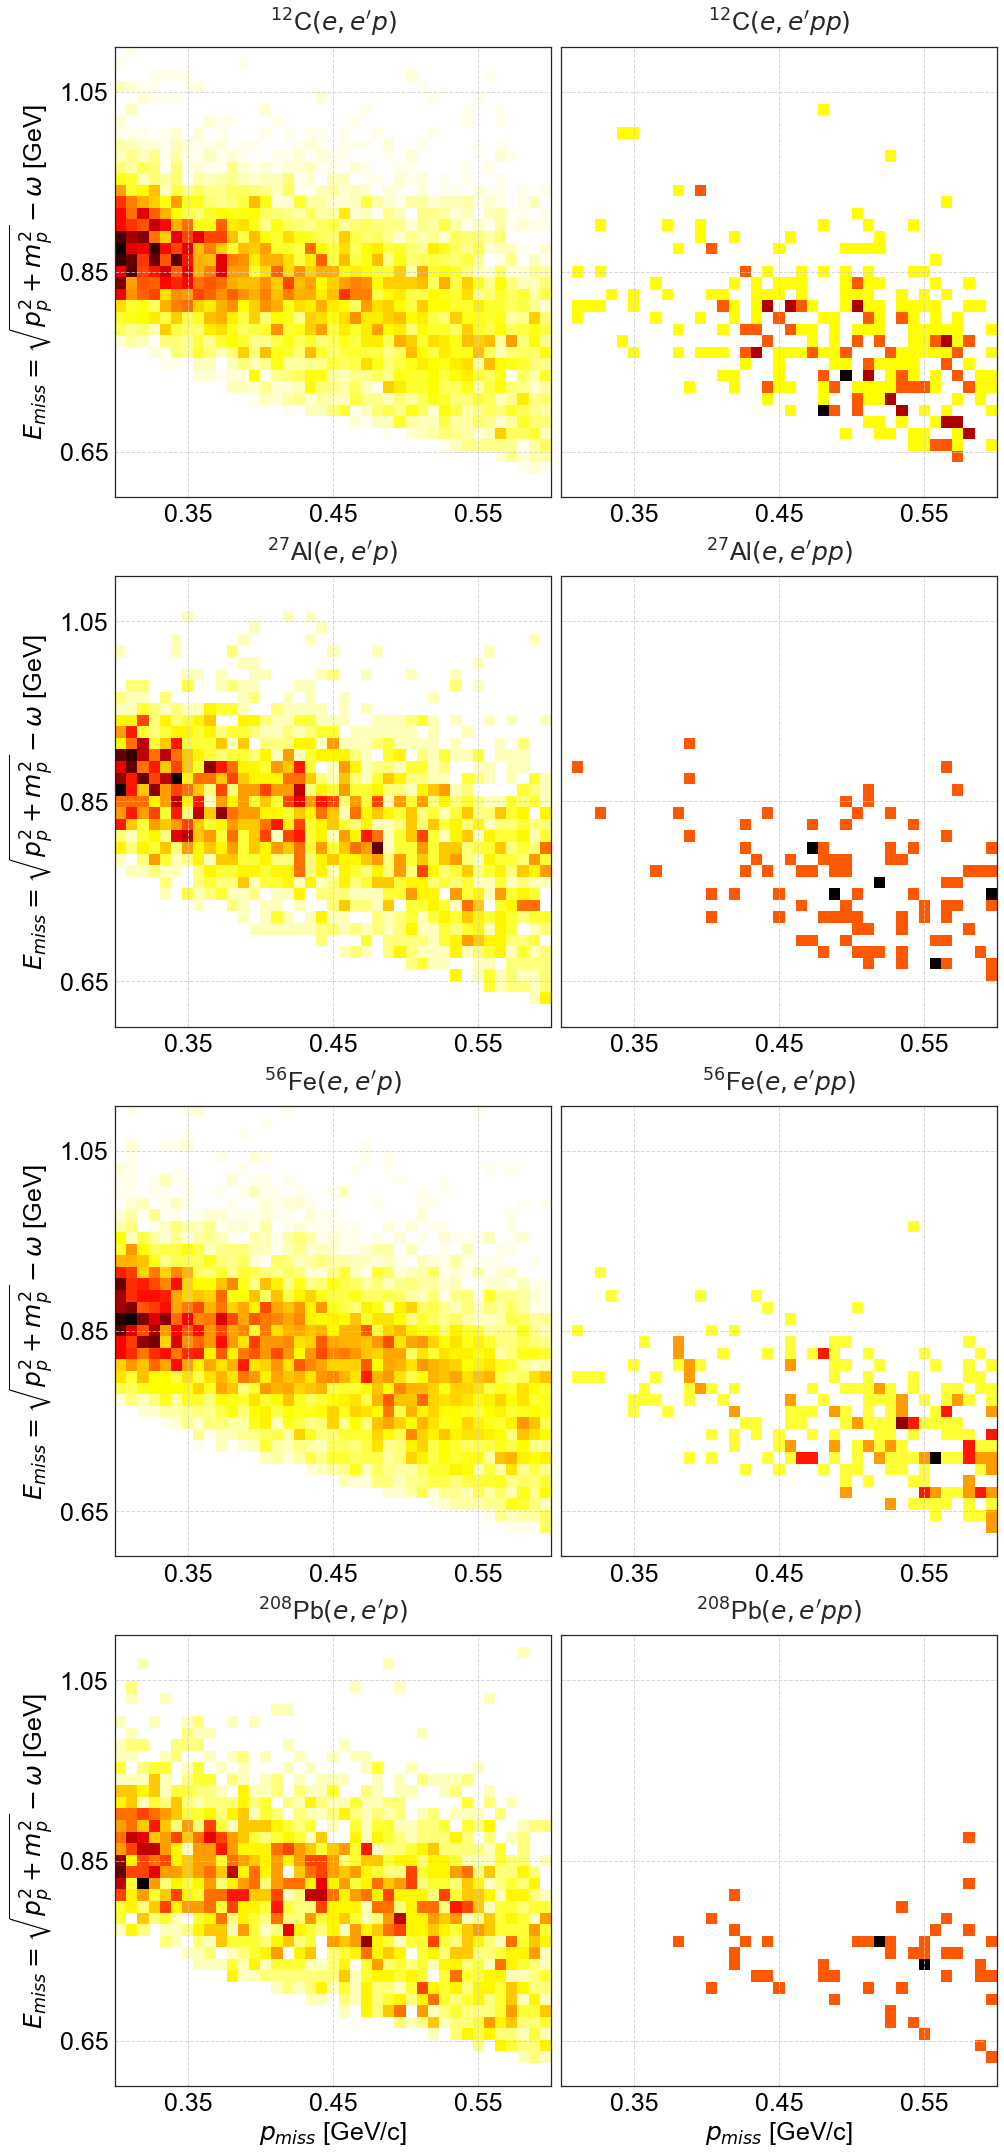

In [12]:
fig = plt.figure(figsize=(14,30))
for i_tgt,(target,name) in enumerate(zip(['C12','Al27','Fe56','Pb208']
                       ,['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])):    

    ax = fig.add_subplot(4,2,2*i_tgt+1)
    Pmiss = eep_300Pmiss600_NoFid[target]['Pmiss3Mag']
    Emiss = np.sqrt(np.square(eep_300Pmiss600_NoFid[target]['Plead_P'])+np.square(0.938))-eep_300Pmiss600_NoFid[target]['omega']
    h_ep = plot_2d_hist( Pmiss,Emiss,bins=(np.linspace(0.3,0.6,40),np.linspace(0.6,1.1,40)),ax=ax)
    set_axes(ax
             ,r'$p_{miss}$ [GeV/c]'  if i_tgt==3 else ''
             ,r'$E_{miss}=\sqrt{p_p^2+m_p^2}-\omega$ [GeV]'
             ,xticks=[0.35,0.45,0.55],yticks=[0.65,0.85,1.05]
             ,title=name+r"$(e,e'p)$"
             ,do_add_grid=True
                )
    
    ax = fig.add_subplot(4,2,2*i_tgt+2)
    Pmiss = eepp_300Pmiss600_NoFid[target]['Pmiss3Mag']
    Emiss = np.sqrt(np.square(eepp_300Pmiss600_NoFid[target]['Plead_P'])+np.square(0.938))-eepp_300Pmiss600_NoFid[target]['omega']
    h_epp = plot_2d_hist( Pmiss,Emiss,bins=(np.linspace(0.3,0.6,40),np.linspace(0.6,1.1,40)),ax=ax)
    set_axes(ax
             ,r'$p_{miss}$ [GeV/c]'     if i_tgt==3 else ''           
             ,xticks=[0.35,0.45,0.55],yticks=[0.65,0.85,1.05]
             ,title=name+r"$(e,e'pp)$"
             ,do_add_grid=True
                )
    ax.get_yaxis().set_major_formatter(ticker.NullFormatter())
plt.tight_layout()